In [15]:
#!/usr/bin/env python3

import numpy as np
import random
import math

class Line:
    """An object used to create a line from two points

    :param start: First point used to generate the line. It's an
                  array of form [x,y].
    :type start: numpy.ndarray
    :param end: Second point used to generate the line. It's an
                array of form [x,y].
    :type end: numpy.ndarray
    """
    def __init__(self, start: np.ndarray, end: np.ndarray):
        if np.shape(start)!= (2,):
            raise ValueError("Start point must have the shape (2,)")
        if np.shape(end) != (2,):
            raise ValueError("End point must have the shape (2,)")
        if (start==end).all():
            raise ValueError("Start and end points must be different")
        
        # Calculate useful properties of the line
        self.start = start
        self.line = end - start
        self.length = np.linalg.norm(self.line)
        self.unit_line = self.line / self.length
        
    def point_dist(self, point: np.ndarray):
        """Calculate the distance between a point and a line segment.
        adapted from code given by clued__init__ found here:
        https://www.py4u.net/discuss/186227

        To calculate the closest distance to a line, we calculate
        the orthogonal distance from the point to the line.

        :param point: Numpy array of form [x,y], describing the point.
        :type point: numpy.ndarray
        :return: The minimum distance to a point.
        :rtype: float
        """
        if np.shape(point)!= (2,):
            raise ValueError("Start point must have the shape (2,)")
        # compute the perpendicular distance to the theoretical infinite line
        return np.linalg.norm(np.cross(self.line, self.start - point)) /self.length
    
    def equation(self):
        """Calculate the basic linear equation parameters useful for plotting

        :return: (m, c) where m is the gradient of the line
                 and c is the y intercept
        :rtype: tuple of floats
        """
        # adding 1e-5 to handle cases where self.line[0] is zero
        m = self.line[1]/(self.line[0]+1e-5)
        c = self.start[1] - m*self.start[0]
        return (m, c)

def np_polar2cart(polar_points):
    center = np.array([0,0])
    r = polar_points.T[0,]
    theta = polar_points.T[1,]
    x = r*np.cos(theta) # theta -> radians
    y = r*np.sin(theta)
    return np.array([x, y]).T    

def np_cart2polar(cart_points):
    """
    cart_points: n x 2 matrix of points in cartesian coordinates
    """
    r = np.linalg.norm(cart_points, axis=1)
    theta = np.arctan2(cart_points[:,1], cart_points[:,0])
    return np.array([r, theta]).T 
    
def process_data(range_data: np.ndarray, max_angle: float, min_angle: float, max_range: float, min_range: float, sigma: float, rf_max_pts: int, reduce_bool: bool=True):
	"""
	Filter data by removing all perceived points outside defined boundary
	"""
	
	angles = np.linspace(min_angle,max_angle,range_data.shape[0])
	processed_data = np_polar2cart(np.array([range_data,angles]).T)
	out_of_min_range = np.where(range_data<min_range)[0]
	out_of_max_range = np.where(range_data>max_range)[0]
	processed_data = np.delete(processed_data, np.concatenate([out_of_max_range,out_of_min_range]), axis=0)
	if reduce_bool:
		processed_data = reduction_filter(data_points=processed_data, sigma=sigma, rf_max_pts=rf_max_pts)
            
	return processed_data

def RANSAC(points: list, dist_thresh: int, iterations: int, thresh_count: int):

	if len(points) == 0:
		return False 
	  
	indexes = list(range(0, len(points)))
	inliers = dict()
	for _ in range(0,iterations):
		sample_points = indexes.copy()
		random.shuffle(sample_points)
		start = sample_points.pop()
		end = sample_points.pop()

		if((start,end) not in inliers) and ((end,start) not in inliers):
			inliers[(start,end)]=[]
			line = Line(points[start],points[end])
			for point_idx in sample_points:
				if line.point_dist(points[point_idx]) < dist_thresh:
					inliers[(start,end)].append(points[point_idx])

	best_pair = None

	for cur_pair in inliers:
		if best_pair == None:
			best_pair = cur_pair
		elif len(inliers[cur_pair]) > len(inliers[best_pair]):
			best_pair = cur_pair
             
	if len(inliers[best_pair]) < thresh_count:
		return False
	best_point_1 = points[best_pair[0]]
	best_point_2 = points[best_pair[1]]        
	return best_point_1, best_point_2, inliers[best_pair]

def RANSAC_get_line_params(points: list, dist_thresh: int, iterations: int, thresh_count: int):
    
    d_m_c_endPts = [] # d: perpendicular distance, m: slope, c: constant in line equation
    while True:
        params = RANSAC(points, dist_thresh, iterations, thresh_count)
        if params:
            p1, p2, best_inliers = params
            # dtype(best_inliers): list of array of individual points
        else:
            break

        # updating points list by removing all inliers that were found
        for point in best_inliers:
            points = [x for x in points if not (x == point).all()]
        best_line = Line(p1, p2)
        m, c = best_line.equation()

        # getting starting and end points of individual lines
        best_inliers_arr = np.array(best_inliers)
        min_x, max_x = min(best_inliers_arr[:, 0]), max(best_inliers_arr[:, 0])
        min_y, max_y = min(best_inliers_arr[:, 1]), max(best_inliers_arr[:, 1])
        # each row of end_points consists of 'x' and 'y' coordinates
        if abs(min_x-max_x) >= abs(min_y-max_y):
            end_points = np.array([[min_x, m*min_x+c], [max_x, m*max_x+c]])
        else:
            end_points = np.array(
                [[(min_y-c)/m, min_y], [(max_y-c)/m, max_y]])

        center_wrt_laser = np.array([-0.45, 0]) # location of center of robot w.r.t. laser scanner
        d = best_line.point_dist(center_wrt_laser) # distance fom the center of the Robile
        d_m_c_endPts.append([d, m, c, end_points]) 
    return d_m_c_endPts

def online_get_line_params(points_array: np.ndarray, e=0.45, incr=0.01, max_dist=400, k=3):
    """
    arguments:
    points  : array of data points representing center of each occupied grid cell
    e       : allowed fraction of deviation of sum of distances between consecutive points and 
    the total length  of the line
    incr    : increment in the error values with the number of points
    max_dist: maximum distance between consecutive points allowed in a line segment
    k       : minimum number of points required in a line segment
    """

    # Convert the data points into list of ordered points
    points_polar = np_cart2polar(points_array)
    points_polar_sorted = points_polar[points_polar[:, 1].argsort()]
    points_cart = np_polar2cart(points_polar_sorted)
    points = [point for point in points_cart]

    grouped_points = []
    d_m_c_endPts = []           # line parameters: perpendicular distance, slope and deviation from laser scanner
    point = points[0]
    current_group = [point]
    aj = point                  # starting point of current line segment
    dist_sum = 0                # sum of distances between consecutive points o a line segment
    ak = point                  # latest point added to a line
    ek = e                      # incremented error

    for point_idx in range(1,len(points)): 
        dist_sum += np.linalg.norm(ak-points[point_idx])
        full_dist_ratio = np.linalg.norm(aj-points[point_idx])/dist_sum
        end_dist_ratio = 1 
        
        if len(current_group) >= k:
            prev_ak = points[point_idx-2]
            end_dist_ratio = (np.linalg.norm(prev_ak-points[point_idx])/ (np.linalg.norm(prev_ak-ak)+np.linalg.norm(ak-points[point_idx])))
        
        if(full_dist_ratio > 1-ek and end_dist_ratio > 1-e and np.linalg.norm(ak-points[point_idx]) <= max_dist):
            current_group.append(points[point_idx])
            ak = points[point_idx]
            ek += incr

        else:
            if len(current_group) >= k:
                grouped_points.append(np.array(current_group))
                
            current_group = [points[point_idx]]
            aj = points[point_idx]
            dist_sum = 0
            ak = points[point_idx]
            ek = e
            
    if len(current_group) >= k:
        grouped_points.append(np.array(current_group))

    if grouped_points:
        for points_on_line in grouped_points:
            line_segment = Line(points_on_line[0], points_on_line[-1])
            end_pts = np.array([points_on_line[0], points_on_line[-1]])
            m, c = line_segment.equation()
            center_wrt_laser = np.array([-0.45, 0])       # location of center of robot with respect to laser scanner
            d = line_segment.point_dist(center_wrt_laser) # distance fom the center of the Robile
            d_m_c_endPts.append([d, m, c, end_pts])      
    return d_m_c_endPts
     
def reduction_filter(data_points, sigma, rf_max_pts):

    '''
    Method to reduce number of laser scan points by replacing cluster of points
    with their representative.
    :param data_points: 2D array representing laser scan data in cartesian coordinates
    :param type: np.ndarray
    :param sigma: maximum distance between two consecutive points to consider them 
    in same cluster
    :param type: float    
    :param rf_max_pts: maximum number of points allowed in a cluster
    :param type: int    
    '''
    points_list = list(data_points)
    output = []
    while len(points_list) > 0:
        a_i = points_list.pop(0)
        cur_sum = np.array(a_i)
        i = 1
        while len(points_list) > 0 and abs(a_i[0] - points_list[0][0]) < sigma \
        and i <= rf_max_pts:
            cur_sum += np.array(points_list.pop(0))
            i += 1
        output.append(cur_sum/i)
    return np.array(output)


1 {POPDSFSDTGDGBDSB}
Left
HEHEHEHEH [0]
sliced_array_left: [ 1  2  3  4  5  6  7  8  9 10]
sliced_array_right: [11 12 13 14 15 16 17 18 19 20]


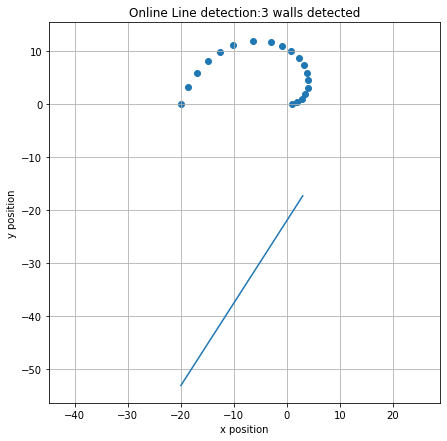

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import inf
import numpy as np

def slice_data(laser_data):
    # Calculate the length of the array
    length = len(laser_scan)
    # Calculate the midpoint of the array
    midpoint = length // 2
    # Slice the array into two equal halves
    left = laser_scan[:midpoint]
    right = laser_scan[midpoint:]
    print("sliced_array_left:", left)
    print("sliced_array_right:", right )
    
    return left,right


def process_data(range_data: np.ndarray, max_angle: float, min_angle: float, max_range: float, min_range: float, sigma: float, rf_max_pts: int, reduce_bool: bool=True):
	"""
	Filter data by removing all perceived points outside defined boundary
	"""
	
	angles = np.linspace(min_angle,max_angle,range_data.shape[0])
	processed_data = np_polar2cart(np.array([range_data,angles]).T)
	out_of_min_range = np.where(range_data<min_range)[0]
	out_of_max_range = np.where(range_data>max_range)[0]
	processed_data = np.delete(processed_data, np.concatenate([out_of_max_range,out_of_min_range]), axis=0)
	if reduce_bool:
		processed_data = reduction_filter(data_points=processed_data, sigma=sigma, rf_max_pts=rf_max_pts)
            
	return processed_data


# laser_scan = np.array([inf, inf, inf, inf, inf, inf, inf, inf, 5.34049654006958, inf, inf, inf, 5.3821635246276855, 5.276798725128174, 5.174829483032227, 5.07206392288208, 4.9817094802856445, 4.899624347686768, 4.837193489074707, 4.756162166595459, 4.685381889343262, 4.6113104820251465, 4.5588297843933105, 4.471668720245361, 4.435177803039551, 4.376786708831787, 4.338528156280518, 4.303784370422363, 4.25106954574585, 4.215467929840088, 4.1636786460876465, 4.1282877922058105, 4.09890604019165, 4.05342960357666, 4.044239521026611, 4.008484363555908, 3.979867696762085, 3.9558684825897217, 3.9269649982452393, 3.9200785160064697, 3.8992552757263184, 3.9000914096832275, 3.88501238822937, 3.8674564361572266, 3.860759973526001, 3.8506886959075928, 3.8337221145629883, 3.8403658866882324, 3.8536434173583984, 3.842066526412964, 3.840186595916748, 3.836416482925415, 3.840543746948242, 3.8533830642700195, 3.8662874698638916, 3.8682868480682373, 3.874530553817749, 3.8871521949768066, 3.937655448913574, 3.947767734527588, 3.9466073513031006, 3.9731791019439697, 3.992196798324585, 4.018855571746826, 4.038227558135986, 4.064218521118164, 4.101578235626221, 4.137314319610596, 4.190204620361328, 4.210836410522461, 4.2627363204956055, 4.212058067321777, 4.046998977661133, 3.8890721797943115, 3.738551616668701, 3.6119513511657715, 3.5248072147369385, 3.386545419692993, 3.292936325073242, 3.1923837661743164, 3.1165945529937744, 3.0224366188049316, 2.9581475257873535, 2.8764960765838623, 2.8250269889831543, 2.760852098464966, 2.677640914916992, 2.6286208629608154, 2.589437484741211, 2.543102502822876, 2.480839252471924, 2.4344534873962402, 2.409956455230713, 2.3557560443878174, 2.320472240447998, 2.2935290336608887, 2.2688724994659424, 2.2388877868652344, 2.219515562057495, 2.1745858192443848, 2.142568349838257, 2.1205928325653076, 2.0900886058807373, 2.0878214836120605, 2.0476584434509277, 2.0514204502105713, 2.03082013130188, 2.016268253326416, 2.005455493927002, 1.9813129901885986, 1.9703423976898193, 1.9680969715118408, 1.9521119594573975, 1.948240041732788, 1.950392723083496, 1.9318422079086304, 1.9211255311965942, 1.914565086364746, 1.9053006172180176, 1.8997119665145874, 1.9022542238235474, 1.9073574542999268, 3.049262523651123, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
# arr_len = len(laser_scan)
# # left = arr_len/2
# # right = 
# my_array = [1, 2, 3, 4, 5,0,6]
# start_index = 0
# half_left_end_index = int((len(my_array))//2)
# half_right_start_index = int((len(my_array))//2)+1

# end_index = len(my_array)
# sliced_array_left = my_array[start_index:half_left_end_index]
# sliced_array_right = my_array[half_right_start_index:end_index]

# laser_scan = np.array([inf, inf, inf, inf, inf, inf, inf, inf, 5.34049654006958, inf, inf, inf, 5.3821635246276855, 5.276798725128174, 5.174829483032227, 5.07206392288208, 4.9817094802856445, 4.899624347686768, 4.837193489074707, 4.756162166595459, 4.685381889343262, 4.6113104820251465, 4.5588297843933105, 4.471668720245361, 4.435177803039551, 4.376786708831787, 4.338528156280518, 4.303784370422363, 4.25106954574585, 4.215467929840088, 4.1636786460876465, 4.1282877922058105, 4.09890604019165, 4.05342960357666, 4.044239521026611, 4.008484363555908, 3.979867696762085, 3.9558684825897217, 3.9269649982452393, 3.9200785160064697, 3.8992552757263184, 3.9000914096832275, 3.88501238822937, 3.8674564361572266, 3.860759973526001, 3.8506886959075928, 3.8337221145629883, 3.8403658866882324, 3.8536434173583984, 3.842066526412964, 3.840186595916748, 3.836416482925415, 3.840543746948242, 3.8533830642700195, 3.8662874698638916, 3.8682868480682373, 3.874530553817749, 3.8871521949768066, 3.937655448913574, 3.947767734527588, 3.9466073513031006, 3.9731791019439697, 3.992196798324585, 4.018855571746826, 4.038227558135986, 4.064218521118164, 4.101578235626221, 4.137314319610596, 4.190204620361328, 4.210836410522461, 4.2627363204956055, 4.212058067321777, 4.046998977661133, 3.8890721797943115, 3.738551616668701, 3.6119513511657715, 3.5248072147369385, 3.386545419692993, 3.292936325073242, 3.1923837661743164, 3.1165945529937744, 3.0224366188049316, 2.9581475257873535, 2.8764960765838623, 2.8250269889831543, 2.760852098464966, 2.677640914916992, 2.6286208629608154, 2.589437484741211, 2.543102502822876, 2.480839252471924, 2.4344534873962402, 2.409956455230713, 2.3557560443878174, 2.320472240447998, 2.2935290336608887, 2.2688724994659424, 2.2388877868652344, 2.219515562057495, 2.1745858192443848, 2.142568349838257, 2.1205928325653076, 2.0900886058807373, 2.0878214836120605, 2.0476584434509277, 2.0514204502105713, 2.03082013130188, 2.016268253326416, 2.005455493927002, 1.9813129901885986, 1.9703423976898193, 1.9680969715118408, 1.9521119594573975, 1.948240041732788, 1.950392723083496, 1.9318422079086304, 1.9211255311965942, 1.914565086364746, 1.9053006172180176, 1.8997119665145874, 1.9022542238235474, 1.9073574542999268, 3.049262523651123, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
laser_scan = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
point_min = min(laser_scan)
print(point_min, "{POPDSFSDTGDGBDSB}")

# point_min_idx = laser_scan.index(point_min)
point_min_idx  = np.where(laser_scan == point_min)[0]
# point_min_idx = list(point_min_idx)
mid_idx = int((len(laser_scan)-1)/2)
if (point_min_idx) <= mid_idx:
    print('Left')
else:
    print('Right')
print("HEHEHEHEH", point_min_idx)
left, right = slice_data(laser_scan)


temp = laser_scan
# self.blackboard.desired_wall = temp
temp[temp <= 0.05] = 0.6
temp = np.nan_to_num(temp, nan=5)
max_angle =  -1.5707963267948966
min_angle= 1.5707963267948966
max_range= 20.0
min_range= 0.05
sigma= 0.2
rf_max_pts= 30
reduce_bool= True
desired_wall = process_data(range_data= temp, max_angle=max_angle,
                    min_angle= min_angle, max_range= max_range,
                    min_range=min_range, sigma=sigma,
                    rf_max_pts=rf_max_pts, reduce_bool= reduce_bool)  


def online_line_detection_new(points, e=0.1, incr=0.01, max_dist=5, k=5):
    """
    arguments:
    points  : ordered list of arrays of individual points
    e       : allowed fraction of deviation of sum of distances between consecutive points and 
    the total length  of the line
    incr    : increment in the error values with the number of points
    max_dist: maximum distance between consecutive points allowed in a line segment
    k       : minimum number of points required in a line segment
    return: return a list of numpy array containing points grouped into points on the same line
    """
    grouped_points = []
    
    point = points[0]
    current_group = [point]
    aj = point              # starting point of current line segment
    dist_sum = 0            # sum of distances between consecutive points in a line segment
    ak = point              # latest point added to a line
    ek = e                  # incremented error

    for point_idx in range(1,len(points)): 
        dist_sum += np.linalg.norm(ak-points[point_idx])

        # getting ratio between distance b/w first and last point to the sum of distances b/w consecutive points
        full_dist_ratio = np.linalg.norm(aj-points[point_idx])/dist_sum

        # end_dist_ratio is the ratio of distance b/w previous point and new point to the sum of distance b/w
        # privious, current and new point. It is set to 1 until minimum number required in a line is obtained
        end_dist_ratio = 1 
        
        if len(current_group) >= k:
            prev_ak = points[point_idx-2]
            end_dist_ratio = np.linalg.norm(prev_ak-points[point_idx])/ (np.linalg.norm(prev_ak-ak)+np.linalg.norm(ak-points[point_idx]))
        
        if(full_dist_ratio > 1-ek and end_dist_ratio > 1-e and np.linalg.norm(ak-points[point_idx]) <= max_dist):
            current_group.append(points[point_idx])
            ak = points[point_idx]
            ek += incr

        else:
            if len(current_group) >= k:
                grouped_points.append(np.array(current_group))
                
            current_group = [points[point_idx]]
            aj = points[point_idx]
            dist_sum = 0
            ak = points[point_idx]
            ek = e
            
    if len(current_group) >= k:
        grouped_points.append(np.array(current_group))
        # print("grouped_points",grouped_points)
    return grouped_points

lines = online_line_detection_new(desired_wall)

# print(lines)



def points_to_line_new(desired_wall, step=1):
    m, c = np.polyfit(desired_wall[:,0], desired_wall[:,1], 1)
    lims = [desired_wall[0,1], desired_wall[-1,1]]
    lims.sort()
    x_min, x_max = tuple(lims)
    x = np.arange(x_min, x_max+step, step)
    y = m*x+c
    return np.array([x, y])
d_m_c_endPts = []
line_lengths = []
if lines:
    for points_on_line in lines:
        line_segment = Line(points_on_line[0], points_on_line[-1])
        end_pts = np.array([points_on_line[0], points_on_line[-1]])
        m, c = line_segment.equation()
        center_wrt_laser = np.array([-0.45, 0])       # location of center of robot with respect to laser scanner
        d = line_segment.point_dist(center_wrt_laser) # distance fom the center of the Robile
        length = np.linalg.norm(end_pts[1] - end_pts[0])
        line_lengths.append(length)
        d_m_c_endPts.append([d, m, c, end_pts])

    
    # print("d_m_c_endPts",d_m_c_endPts)
    # print("line_lengths",line_lengths)
    best_line = np.max(line_lengths)
    best_line_idx = line_lengths.index(best_line)
    # print(best_line,best_line_idx)
def calculate_slope_angle(slope):
    # Calculate the angle of the slope in radians
    return math.atan(slope)

def calculate_midpoint(endpoint1, endpoint2):
    # Calculate the midpoint between the two endpoints
    midpoint = ((endpoint1[0] + endpoint2[0]) / 2, (endpoint1[1] + endpoint2[1]) / 2)
    return midpoint

def calculate_desired_heading(current_heading, slope_angle):
    # Calculate the desired heading by adding the slope angle to the current heading
    desired_heading = current_heading + slope_angle
    return desired_heading

def generate_twist_command(angular_velocity, linear_velocity):
    # Generate a twist command with the given angular and linear velocities
    twist_command = {'angular': angular_velocity, 'linear': linear_velocity}
    return twist_command    
hihi = d_m_c_endPts[best_line_idx]
# print(hihi)
d=hihi[0]
m=hihi[1]
c=hihi[2]
i=hihi[3]
current_heading = 0.0

# Step 1: Calculate the angle of the slope
slope_angle = calculate_slope_angle(m)
# print("angle",slope_angle)
# Step 2: Calculate the target position (midpoint)
# target_position = calculate_midpoint(endpoint1, endpoint2)

# Step 3: Calculate the desired heading
desired_heading = calculate_desired_heading(current_heading, slope_angle)
# print("heading",desired_heading)
# Step 4: Generate the twist command
angular_velocity = desired_heading
linear_velocity = d
twist_command = generate_twist_command(angular_velocity, linear_velocity)
# def get_length(end_pts):
#     a = end_pts[0]
#     b = end_pts[1]
    
        
        
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)


for line_points in lines:
    line = points_to_line_new(line_points)
    plt.plot(line[0], line[1])
    
plt.scatter(desired_wall[:,1], desired_wall[:,0])
plt.title("Online Line detection:3 walls detected")
plt.xlabel("x position")
plt.ylabel("y position")
plt.axis("equal")
plt.grid()
plt.show()
# plt.savefig("graphs/online_detection")

In [266]:
my_array = [1, 2, 3, 4, 5,0,6]
start_index = 0
half_left_end_index = int((len(my_array))//2)
half_right_start_index = int((len(my_array))//2)+1

end_index = len(my_array)
sliced_array_left = my_array[start_index:half_left_end_index]
sliced_array_right = my_array[half_right_start_index:end_index]

print(sliced_array_left)
print(sliced_array_right)



[1, 2, 3]
[5, 0, 6]


In [267]:
def process_data(range_data: np.ndarray, max_angle: float, min_angle: float, max_range: float, min_range: float, sigma: float, rf_max_pts: int, reduce_bool: bool=True):
	"""
	Filter data by removing all perceived points outside defined boundary
	"""

	angles = np.linspace(min_angle,max_angle,range_data.shape[0])
	processed_data = np.array([range_data,angles]).T # np_polar2cart(np.array([range_data,angles]).T)
	out_of_min_range = np.where(range_data<min_range)[0]
	out_of_max_range = np.where(range_data>max_range)[0]
	processed_data = np.delete(processed_data, np.concatenate([out_of_max_range,out_of_min_range]), axis=0)
	processed_data = np_polar2cart(processed_data)
	if reduce_bool:
		processed_data = reduction_filter(data_points=processed_data, sigma=sigma, rf_max_pts=rf_max_pts)
            
	return processed_data


(150,)


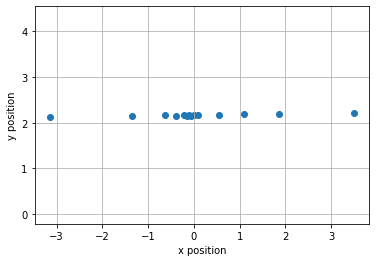

In [268]:
print(laserscan9.shape)
temp = np.array(laserscan9)
temp[temp <= 0.05] = 0.6
temp = np.nan_to_num(temp, nan=5)
max_angle =  1.5707963267948966
min_angle= -1.5707963267948966
max_range= 5.0
min_range= 0.05
sigma= 0.02
rf_max_pts= 30
reduce_bool= True

desired_wall = process_data(range_data= temp, max_angle=max_angle,
                    min_angle= min_angle, max_range= max_range,
                    min_range=min_range, sigma=sigma,
                    rf_max_pts=rf_max_pts, reduce_bool= reduce_bool)
desired_wall
plt.scatter(desired_wall[:,1], desired_wall[:,0])
plt.xlabel("x position")
plt.ylabel("y position")
plt.axis("equal")
plt.grid()
plt.show()

In [269]:
def plotgen(laser_scan,title):
    temp = np.array(laser_scan)
    temp[temp <= 0.05] = 0.6
    temp = np.nan_to_num(temp, nan=5)
    max_angle =  1.5707963267948966
    min_angle= -1.5707963267948966
    max_range= 20.0
    min_range= 0.05
    sigma= 0.2
    rf_max_pts= 30
    reduce_bool= True

    # print('laser_scan', temp)
    desired_wall = process_data(range_data= temp, max_angle=max_angle,
                        min_angle= min_angle, max_range= max_range,
                        min_range=min_range, sigma=sigma,
                        rf_max_pts=rf_max_pts, reduce_bool= reduce_bool) 
    # print('desired_wall', desired_wall)
    grouped_points = online_line_detection_new(desired_wall)
    d_m_c_endPts = []
    line_lengths = []
    if grouped_points:
        for points_on_line in grouped_points:
            line_segment = Line(points_on_line[0], points_on_line[-1])
            end_pts = np.array([points_on_line[0], points_on_line[-1]])
            print("end-points: ", end_pts)
            m, c = line_segment.equation()
            center_wrt_laser = np.array([-0.45, 0])       # location of center of robot with respect to laser scanner
            d = line_segment.point_dist(center_wrt_laser) # distance fom the center of the Robile
            length = np.linalg.norm(end_pts[1] - end_pts[0])
            line_lengths.append(length)
            d_m_c_endPts.append([d, m, c, end_pts])
        best_line = np.max(line_lengths)
        best_line_idx = line_lengths.index(best_line)

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)


    for line_points in grouped_points:
        line = points_to_line_new(line_points)
        plt.plot(line[0], line[1])

    plt.scatter(desired_wall[:,0], desired_wall[:,1])
    plt.title("Online Line detection: "+ title)
    plt.xlabel("x position")
    plt.ylabel("y position")
    plt.axis("equal")
    plt.grid()
    plt.show()

laserscan2 = np.array([2.2487223148345947, 2.267108678817749, 2.26194167137146, 2.288787603378296, 2.257340908050537, 2.27173113822937, 2.276121139526367, 2.2830564975738525, 2.307081460952759, 2.307204484939575, 2.3210394382476807, 2.320462465286255, 2.3212928771972656, 2.366645097732544, 2.3629038333892822, 2.3779327869415283, 2.393266439437866, 2.4282538890838623, 2.437056064605713, 2.4629433155059814, 2.4853711128234863, 2.5087497234344482, 2.5225777626037598, 2.5640411376953125, 2.5932812690734863, 2.61423659324646, 2.6677207946777344, 2.695066213607788, 2.7347052097320557, 2.7691009044647217, 2.7882235050201416, 2.8692679405212402, 2.88916015625, 2.947725772857666, 3.0009677410125732, 3.0903208255767822, 3.124823570251465, 3.1944057941436768, 3.2414608001708984, 3.319119691848755, 3.409202814102173, 3.484463930130005, 3.5882129669189453, 3.670459508895874, 3.773916006088257, 3.861710548400879, 3.999905586242676, 4.131332874298096, 4.2552103996276855, 4.4030938148498535, 4.5736918449401855, 4.734750270843506, 4.951412200927734, 5.1596221923828125, 5.3803839683532715, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
plotgen(laserscan2," single wall, robot away")

laserscan3 = np.array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 5.336818218231201, 4.751664161682129, 4.286032676696777, 3.910174608230591, 3.6166903972625732, 3.345024585723877, 3.120363235473633, 2.9233405590057373, 2.7242753505706787, 2.572949171066284, 2.467066526412964, 2.323631763458252, 2.2093265056610107, 2.132107734680176, 2.027250051498413, 1.9547024965286255, 1.8916891813278198, 1.809306025505066, 1.735144019126892, 1.6886991262435913, 1.6423364877700806, 1.5807346105575562, 1.5350148677825928, 1.4872227907180786, 1.4516469240188599, 1.4238307476043701, 1.3971542119979858, 1.373594045639038, 1.3411753177642822, 1.2908507585525513, 1.2692921161651611, 1.237134337425232, 1.2328670024871826, 1.205151915550232, 1.1690789461135864, 1.1824073791503906, 1.2178963422775269, 1.2563419342041016, 1.3089776039123535, 1.3351738452911377, 1.3518519401550293, 1.4229882955551147, 1.4684430360794067, 1.51608407497406, 1.5781357288360596, 1.661087989807129, 1.7451677322387695, 1.815567135810852, 1.9013773202896118, 2.023113489151001, 2.1165411472320557, 2.245482921600342, 2.42686128616333, 2.604210376739502, 2.816659450531006, 3.049912929534912, 3.3459486961364746, 3.6808507442474365, 4.099649429321289, 4.667034149169922, 5.403124809265137, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
# plotgen(laserscan3," facing corner outwards")

laserscan4 = np.array([1.9019191265106201, 1.904688835144043, 1.9104937314987183, 1.9006577730178833, 1.9239997863769531, 1.91264009475708, 1.9250755310058594, 1.9206398725509644, 1.9488046169281006, 1.9494149684906006, 1.9494996070861816, 1.9654042720794678, 1.9761430025100708, 1.9937177896499634, 1.9831445217132568, 2.0239150524139404, 2.031188726425171, 2.0304172039031982, 2.064368963241577, 2.0908045768737793, 2.096886157989502, 2.1192286014556885, 2.1602272987365723, 2.1591339111328125, 2.2102723121643066, 2.2092623710632324, 2.251845121383667, 2.2662675380706787, 2.343449115753174, 2.3475701808929443, 2.377485513687134, 2.4376301765441895, 2.4620659351348877, 2.5195472240448, 2.5592381954193115, 2.608759641647339, 2.660149335861206, 2.695319890975952, 2.777522563934326, 2.836670398712158, 2.907292366027832, 2.8613181114196777, 2.8200902938842773, 2.7713706493377686, 2.730846643447876, 2.682558536529541, 2.645489454269409, 2.610706329345703, 2.581643581390381, 2.5432956218719482, 2.5127642154693604, 2.4631400108337402, 2.452346086502075, 2.403609275817871, 2.395369291305542, 2.3830268383026123, 2.353431224822998, 2.347309112548828, 2.3220784664154053, 2.3044373989105225, 2.2841532230377197, 2.262617588043213, 2.266378879547119, 2.2597615718841553, 2.248108386993408, 2.223125457763672, 2.2236812114715576, 2.209618330001831, 2.2034411430358887, 2.2024126052856445, 2.205944061279297, 2.2010443210601807, 2.2151055335998535, 2.201939105987549, 2.193826913833618, 2.1977932453155518, 2.199497938156128, 2.2055060863494873, 2.1986796855926514, 2.194591522216797, 2.2195510864257812, 2.2210421562194824, 2.219942808151245, 2.251648426055908, 2.235271453857422, 2.2566518783569336, 2.2583954334259033, 2.285109281539917, 2.3076672554016113, 2.3006107807159424, 2.337445020675659, 2.327425479888916, 2.360600233078003, 2.383882761001587, 2.4125895500183105, 2.4358956813812256, 2.432908058166504, 2.4817821979522705, 2.479749917984009, 2.540510654449463, 2.5520143508911133, 3.898038387298584, 3.9486825466156006, 4.030933380126953, 4.0719895362854, 4.144503116607666, 4.21905517578125, 4.29539155960083, 4.362069606781006, 4.451772212982178, inf, 3.2039871215820312, 3.1497182846069336, 2.7625975608825684, 3.302138328552246, 3.386793851852417, 3.452606678009033, 3.560263156890869, 3.6442248821258545, 3.7568166255950928, 3.8764350414276123, 3.995908498764038, 4.126535892486572, 4.26494026184082, 4.429994583129883, 4.584504127502441, 4.766512393951416, 4.981614112854004, 5.203078269958496, 5.444076061248779, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])

# plotgen(laserscan4," 3 walls-1")

laserscan5 = np.array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 5.299363613128662, inf, inf, inf, 5.369235992431641, 5.302106857299805, 5.2386474609375, 5.170553207397461, 5.089540004730225, 5.036855697631836, 4.991007328033447, 4.9163689613342285, 4.870974540710449, 4.837757110595703, 4.779064655303955, 4.733462333679199, 4.7050065994262695, 4.648715019226074, 4.6377339363098145, 4.605897426605225, 4.5723114013671875, 4.5491533279418945, 4.518019199371338, 4.50205135345459, 4.490082740783691, 4.46147346496582, 4.46087121963501, 4.437257289886475, 4.425017356872559, 4.3974761962890625, 4.418613433837891, 4.400631904602051, 4.3988142013549805, 4.399228572845459, 4.402556419372559, 4.393971920013428, 4.406228065490723, 4.411811828613281, 4.415096282958984, 4.409397125244141, 4.449922561645508, 4.461243152618408, 4.458112716674805, 4.485202789306641, 4.506302356719971, 4.535826206207275, 4.563133239746094, 4.5799336433410645, 4.604580402374268, 4.655764579772949, 4.691521167755127, 4.699363708496094, 4.746194839477539, 4.806762218475342, 4.8519206047058105, 4.8912248611450195, 4.933862209320068, 4.999595642089844, 5.042494297027588, 4.88209342956543, 4.701089382171631, 4.559398651123047, 4.4178385734558105, 4.272356033325195, 4.161427974700928, 4.055165767669678, 3.9379091262817383, 3.840219736099243, 3.7546658515930176, 3.6674702167510986, 3.575676441192627, 3.5100646018981934, 3.449685573577881, 3.3875114917755127, 3.341482162475586, 3.2763400077819824, 3.2257089614868164, 3.133232593536377, 3.112175941467285, 3.0471785068511963, 3.0191001892089844, 2.9917519092559814, 2.9477427005767822, 2.883349657058716, 2.8713183403015137, 2.8335344791412354, 2.8193914890289307, 2.769962787628174, 2.741259813308716, 2.722698211669922, 2.696030855178833, 2.6794207096099854, 2.667520046234131, 2.633945941925049, 2.6325013637542725, 2.6171135902404785, 2.6309080123901367, 2.841256856918335, 3.116654396057129, 3.4931633472442627, 3.9219119548797607, 4.500145435333252, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
# plotgen(laserscan5," 3 walls detected")

# laserscan6 = np.array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 5.439792156219482, 5.252654552459717, 5.08114767074585, 4.938161373138428, 4.757474422454834, 4.629051208496094, 4.515872955322266, 4.407773017883301, 4.279910087585449, 4.185387134552002, 4.046849250793457, 3.9783072471618652, 3.9045004844665527, 3.81931209564209, 3.7429990768432617, 3.674633741378784, 3.61535906791687, 3.5632126331329346, 3.4913196563720703, 3.448793649673462, 3.3745527267456055, 3.3379101753234863, 3.270026445388794, 3.2252449989318848, 3.1909523010253906, 3.164794445037842, 3.122715711593628, 3.0866243839263916, 3.0460398197174072, 3.0197091102600098, 3.0014843940734863, 2.959984302520752, 2.9545652866363525, 2.926947832107544, 2.907890558242798, 2.8897409439086914, 2.8666484355926514, 2.8357419967651367, 2.847578763961792, 2.807290554046631, 2.8036344051361084, 2.7992055416107178, 2.7903332710266113, 2.7817373275756836, 2.789647102355957, 2.754697799682617, 2.753545045852661, 2.7711431980133057, 2.7631418704986572, 2.7374908924102783, 2.763638496398926, 2.759582996368408, 2.7790606021881104, 2.7499263286590576, 2.7690515518188477, 2.7654032707214355, 2.784771680831909, 2.773632049560547, 2.8005900382995605, 2.807598114013672, 2.8191545009613037, 2.8528640270233154, 2.859473943710327, 2.8668618202209473, 2.8891992568969727, 2.885478973388672, 2.9240264892578125, 2.957240581512451, 2.9553959369659424, 3.004955768585205, 3.041161060333252, 3.067945718765259, 3.107017993927002, 3.146920680999756, 3.1765084266662598, 3.1997697353363037, 3.266113042831421, 3.307647943496704, 3.361003875732422, 3.376081943511963, 3.4426612854003906, 3.5225892066955566, 3.5610787868499756, 3.6376442909240723, 3.7221076488494873, 3.7750701904296875, 3.840404987335205, 3.945981025695801, 4.017290115356445, 4.104419708251953, 4.214559078216553, 4.302239894866943, 4.4455461502075195, 4.544896125793457, 4.690487384796143, 4.837141990661621, 4.972894191741943, 5.13293981552124, 5.324284076690674, 5.509856224060059, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
# plotgen(laserscan6," straight wall")

laserscan7 = np.array([4.074173927307129, 3.977905750274658, 3.888476848602295, 3.768773317337036, 3.694453477859497, 3.602126359939575, 3.5202009677886963, 3.4746484756469727, 3.3878724575042725, 3.318815231323242, 3.2543439865112305, 3.223367214202881, 3.1452853679656982, 3.1111769676208496, 3.0525543689727783, 3.0144193172454834, 2.971345901489258, 2.9192209243774414, 2.8799002170562744, 2.8521223068237305, 2.831660509109497, 2.8061771392822266, 2.7642369270324707, 2.7270281314849854, 2.718935251235962, 2.6869068145751953, 2.6639790534973145, 2.6451172828674316, 2.6147096157073975, 2.600914478302002, 2.5979154109954834, 2.5915801525115967, 2.5441298484802246, 2.5455191135406494, 2.5448896884918213, 2.539273500442505, 2.5010178089141846, 2.5140490531921387, 2.5011167526245117, 2.509549379348755, 2.5043468475341797, 2.494471311569214, 2.484316349029541, 2.4896585941314697, 2.5005698204040527, 2.4836654663085938, 2.497765064239502, 2.499113082885742, 2.4963150024414062, 2.503648042678833, 2.512683391571045, 2.524634838104248, 2.534409761428833, 2.520190954208374, 2.5602352619171143, 2.5729260444641113, 2.5760750770568848, 2.5835721492767334, 2.613577127456665, 2.618100166320801, 2.628195285797119, 2.6807823181152344, 2.686256170272827, 2.7001476287841797, 2.734407424926758, 2.75193452835083, 2.784212350845337, 2.838704824447632, 2.8545408248901367, 2.9057939052581787, 2.920215129852295, 2.9716763496398926, 2.9947853088378906, 3.0640347003936768, 3.0807504653930664, 3.1484169960021973, 3.200488567352295, 3.248812675476074, 3.330359697341919, 3.3902437686920166, 3.4617531299591064, 3.5421242713928223, 3.6036369800567627, 3.708527088165283, 3.7833023071289062, 3.863290309906006, 3.969125986099243, 4.071430206298828, 4.188868999481201, 4.337733268737793, 4.461958408355713, 4.588141441345215, 4.75945520401001, 4.936029434204102, 5.1065263748168945, 5.301799774169922, 5.543514728546143, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
# plotgen(laserscan7," straight wall at an angle")

laserscan8 = np.array([1.860351324081421, 1.831279993057251, 1.7915058135986328, 1.766451120376587, 1.7600491046905518, 1.7425577640533447, 1.7236064672470093, 1.6997084617614746, 1.7054380178451538, 1.6731197834014893, 1.6400865316390991, 1.6373895406723022, 1.6334127187728882, 1.6117949485778809, 1.608316421508789, 1.5851857662200928, 1.5709986686706543, 1.5646052360534668, 1.564508080482483, 1.5610687732696533, 1.5678248405456543, 1.5540626049041748, 1.535187005996704, 1.5312111377716064, 1.5317937135696411, 1.5400553941726685, 1.5265623331069946, 1.5293301343917847, 1.5372920036315918, 1.5304876565933228, 1.5261348485946655, 1.5129629373550415, 1.5290920734405518, 1.541378378868103, 1.536346197128296, 1.5187007188796997, 1.5543909072875977, 1.555543065071106, 1.5644733905792236, 1.544842004776001, 1.5695345401763916, 1.5776180028915405, 1.5867706537246704, 1.582876205444336, 1.6136165857315063, 1.6291512250900269, 1.633415699005127, 1.6523973941802979, 1.6744095087051392, 1.6844998598098755, 1.689892053604126, 1.7052412033081055, 1.7176157236099243, 1.7445954084396362, 1.7921674251556396, 1.8065224885940552, 1.8170288801193237, 1.8414154052734375, 1.8707338571548462, 1.921754240989685, 1.9331603050231934, 1.9660104513168335, 2.0038344860076904, 2.044991970062256, 2.076035261154175, 2.1253936290740967, 2.157541513442993, 2.2075393199920654, 2.2656869888305664, 2.309288740158081, 2.372837781906128, 2.435821771621704, 2.504957437515259, 2.573559045791626, 2.652207851409912, 2.7409820556640625, 2.8263516426086426, 2.9134461879730225, inf, inf, inf, inf, 3.8498904705047607, 3.7962472438812256, 3.881570816040039, 4.087799072265625, 4.298603534698486, 4.395969867706299, 4.874059677124023, 1.8477517366409302, 1.837194561958313, 1.8363319635391235, 1.8259791135787964, 1.821103572845459, 1.8083562850952148, 1.8000684976577759, 1.7837285995483398, 1.7956321239471436, 1.7882966995239258, 1.7751370668411255, 1.7841404676437378, 1.791184902191162, 1.7902601957321167, 1.766564965248108, 1.7849791049957275, 1.7601405382156372, 1.7814619541168213, 1.786316156387329, 1.786349892616272, 1.7755120992660522, 1.7892954349517822, 1.788597583770752, 1.804807186126709, 1.834369421005249, 1.8240628242492676, 1.8398791551589966, 1.8418844938278198, 1.8523247241973877, 1.8605183362960815, 1.8555755615234375, 1.8999202251434326, 1.901045799255371, 1.9392262697219849, 1.958167314529419, 1.9521433115005493, 1.9728349447250366, 2.0061001777648926, 2.0285067558288574, 2.064480781555176, 2.0744447708129883, 2.1132264137268066, 2.122668981552124, 2.1515066623687744, 2.190675735473633, 2.222292423248291, 2.270587921142578, 2.2948739528656006, 2.3427271842956543, 2.400452136993408, 2.4152987003326416, 2.487067461013794, 2.542043447494507, 2.607563018798828, 2.6571836471557617, 2.73370623588562, 2.77937650680542, 2.867279052734375, 2.9564664363861084, 3.036248207092285, 3.122958183288574])
# plotgen(laserscan8," inside the corridor")

laserscan9 = np.array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 5.408536911010742, 5.166977882385254, 4.959658622741699, 4.737438201904297, 4.54447078704834, 4.383631706237793, 4.2235026359558105, 4.082155704498291, 3.9312407970428467, 3.835061550140381, 3.715629816055298, 3.61856746673584, 3.516526222229004, 3.407989740371704, 3.33376145362854, 3.258610725402832, 3.1758322715759277, 3.108311891555786, 3.039994716644287, 2.9898104667663574, 2.919564723968506, 2.8492157459259033, 2.8153505325317383, 2.7731986045837402, 2.734962224960327, 2.679285764694214, 2.631016254425049, 2.6015172004699707, 2.588866710662842, 2.5515849590301514, 2.5222694873809814, 2.467611074447632, 2.4464035034179688, 2.4196200370788574, 2.3817169666290283, 2.3516247272491455, 2.3492543697357178, 2.334530830383301, 2.3067195415496826, 2.275925397872925, 2.269343852996826, 2.280787467956543, 2.2557497024536133, 2.238727331161499, 2.2198755741119385, 2.205535650253296, 2.1987571716308594, 2.1930062770843506, 2.164773464202881, 2.1866455078125, 2.174076795578003, 2.187546730041504, 2.154482841491699, 2.1758456230163574, 2.152249336242676, 2.177593469619751, 2.168408155441284, 2.150322437286377, 2.169217586517334, 2.178715944290161, 2.170778751373291, 2.190448045730591, 2.189082384109497, 2.2035017013549805, 2.2056002616882324, 2.2161974906921387, 2.2242074012756348, 2.2319769859313965, 2.2484209537506104, 2.2721025943756104, 2.2648215293884277, 2.297224998474121, 2.3232429027557373, 2.338514566421509, 2.350304365158081, 2.3776512145996094, 2.415853500366211, 2.423280954360962, 2.450326442718506, 2.4745211601257324, 2.4995596408843994, 2.5394325256347656, 2.5744917392730713, 2.6207010746002197, 2.6519689559936523, 2.6680428981781006, 2.7273054122924805, 2.782834768295288, 2.8216025829315186, 2.8705506324768066, 2.9135329723358154, 2.989964246749878, 3.0384347438812256, 3.0957798957824707, 3.1805014610290527, 3.255239725112915, 3.330247640609741, 3.41630482673645, 3.5178332328796387, 3.603675365447998, 3.7140328884124756, 3.81270694732666, 3.9444525241851807, 4.079836845397949, 4.239139556884766, 4.390803337097168, 4.537552833557129, 4.737908363342285, 4.9452056884765625, 5.15504264831543, 5.3920183181762695, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])

# plotgen(laserscan9," perpenti")






In [270]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

# desired_wall = np.array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 5.397489070892334, 5.161671161651611, 4.935859203338623, 4.723146915435791, 4.538429260253906, 4.396022796630859, 4.22890043258667, 4.072132587432861, 3.972867488861084, 3.840423345565796, 3.7095565795898438, 3.58259654045105, 3.5127673149108887, 3.4263241291046143, 3.3388547897338867, 3.2226955890655518, 3.18636417388916, 3.110659122467041, 3.025893211364746, 2.9919309616088867, 2.9128336906433105, 2.8672704696655273, 2.795044422149658, 2.7727084159851074, 2.7194032669067383, 2.6817500591278076, 2.6285288333892822, 2.591371774673462, 2.5764310359954834, 2.5340638160705566, 2.4780406951904297, 2.4512245655059814, 2.4384961128234863, 2.4188170433044434, 2.394422769546509, 2.3761417865753174, 2.3436458110809326, 2.343327760696411, 2.313692092895508, 2.2903974056243896, 2.276369094848633, 2.2517738342285156, 2.254765748977661, 2.235334873199463, 2.2208099365234375, 2.2149906158447266, 2.1868648529052734, 2.207775354385376, 2.188884973526001, 2.178563117980957, 2.173288583755493, 2.182898998260498, 2.165555715560913, 2.175091505050659, 2.1994621753692627, 2.156057596206665, 2.1695637702941895, 2.1663401126861572, 2.172917604446411, 2.173875570297241, 2.1756057739257812, 2.188622236251831, 2.1853387355804443, 2.209074020385742, 2.2047526836395264, 2.205493927001953, 2.234928607940674, 2.248875141143799, 2.2506487369537354, 2.2600107192993164, 2.2737975120544434, 2.2957990169525146, 2.316192388534546, 2.321516513824463, 2.3539648056030273, 2.397763729095459, 2.4116218090057373, 2.4273183345794678, 2.4455037117004395, 2.48311710357666, 2.5229451656341553, 2.542106866836548, 2.573416233062744, 2.6055800914764404, 2.6618564128875732, 2.6790335178375244, 2.7357189655303955, 2.7574894428253174, 2.8213183879852295, 2.861741542816162, 2.9455506801605225, 2.9729740619659424, 3.0432934761047363, 3.0998406410217285, 3.179569721221924, 3.2353925704956055, 3.3243377208709717, 3.4255549907684326, 3.4822208881378174, 3.611604690551758, 3.7258260250091553, 3.8426313400268555, 3.950190782546997, 4.055665493011475, 4.2281341552734375, 4.382468223571777, 4.539040565490723, 4.7170610427856445, 4.930507183074951, 5.15059232711792, 5.398695945739746, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])


# desired_wall_array = np.array(desired_wall)
# print(desired_wall_array)


# desired_wall_array = np.array(desired_wall)
# print(desired_wall_array)






# def online_line_detection(points, e=0.1, incr=0.01, max_dist=400, k=5):
#     """
#     arguments:
#     points  : ordered list of arrays of individual points
#     e       : allowed fraction of deviation of sum of distances between consecutive points and 
#     the total length  of the line
#     incr    : increment in the error values with the number of points
#     max_dist: maximum distance between consecutive points allowed in a line segment
#     k       : minimum number of points required in a line segment
#     return: return a list of numpy array containing points grouped into points on the same line
#     """
#     grouped_points = []
    
#     point = points[0]
#     current_group = [point]
#     aj = point              # starting point of current line segment
#     dist_sum = 0            # sum of distances between consecutive points in a line segment
#     ak = point              # latest point added to a line
#     ek = e                  # incremented error

#     for point_idx in range(1,len(points)): 
#         dist_sum += np.linalg.norm(ak-points[point_idx])

#         # getting ratio between distance b/w first and last point to the sum of distances b/w consecutive points
#         full_dist_ratio = np.linalg.norm(aj-points[point_idx])/dist_sum

#         # end_dist_ratio is the ratio of distance b/w previous point and new point to the sum of distance b/w
#         # privious, current and new point. It is set to 1 until minimum number required in a line is obtained
#         end_dist_ratio = 1 
        
#         if len(current_group) >= k:
#             prev_ak = points[point_idx-2]
#             end_dist_ratio = np.linalg.norm(prev_ak-points[point_idx])/ (np.linalg.norm(prev_ak-ak)+np.linalg.norm(ak-points[point_idx]))
        
#         if(full_dist_ratio > 1-ek and end_dist_ratio > 1-e and np.linalg.norm(ak-points[point_idx]) <= max_dist):
#             current_group.append(points[point_idx])
#             ak = points[point_idx]
#             ek += incr

#         else:
#             if len(current_group) >= k:
#                 grouped_points.append(np.array(current_group))
                
#             current_group = [points[point_idx]]
#             aj = points[point_idx]
#             dist_sum = 0
#             ak = points[point_idx]
#             ek = e
            
#     if len(current_group) >= k:
#         grouped_points.append(np.array(current_group))
#         print("++++++",grouped_points)
#     return grouped_points

# lines = online_line_detection(desired_wall)
# print(lines)



# def points_to_line(desired_wall, step=1):
#     m, c = np.polyfit(desired_wall[:,1], desired_wall[:,0], 1)
#     lims = [desired_wall[0,1], desired_wall[-1,1]]
#     lims.sort()
#     x_min, x_max = tuple(lims)
#     x = np.arange(x_min, x_max+step, step)
#     y = m*x+c
#     return np.array([x, y])

# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111)


# for line_points in lines:
#     line = points_to_line(line_points)
#     plt.plot(line[0], line[1])
    
# plt.scatter(desired_wall[:,1], desired_wall[:,0])
# plt.title("Online Line detection")
# plt.xlabel("x position")
# plt.ylabel("y position")
# plt.axis("equal")
# plt.grid()
# plt.show()
# plt.savefig("graphs/online_detection")

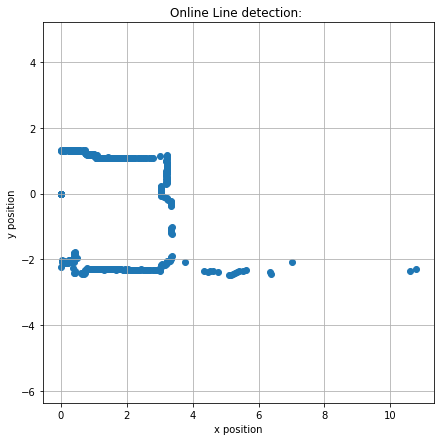

In [271]:
data = abs(np.loadtxt("./laser_data3.csv"))
angles = np.linspace(min_angle,max_angle,data.shape[0])
processed_data = np.array([data,angles]).T
processed_data = np_polar2cart(processed_data)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

plt.scatter(processed_data[:,0], processed_data[:,1])
plt.title("Online Line detection: ")
plt.xlabel("x position")
plt.ylabel("y position")
plt.axis("equal")
plt.grid()
plt.show()

processed_data shape:  (44, 2)


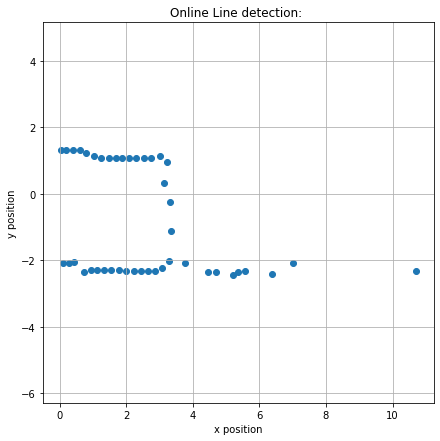

In [272]:
min_angle = -1.57
max_angle = 1.57
data = abs(np.loadtxt("./laser_data3.csv"))
min_rnage = 0.05
max_range = 20.0


angles = np.linspace(min_angle,max_angle,data.shape[0])
processed_data = np.array([data,angles]).T
out_of_min_range = np.where(abs(data)<min_range)[0]
out_of_max_range = np.where(abs(data)>max_range)[0]
processed_data = np.delete(processed_data, np.concatenate([out_of_max_range,out_of_min_range]), axis=0)
processed_data = np_polar2cart(processed_data)

processed_data = reduction_filter(processed_data, sigma=0.2, rf_max_pts=30)

print("processed_data shape: ", processed_data.shape)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

plt.scatter(processed_data[:,0], processed_data[:,1])
plt.title("Online Line detection: ")
plt.xlabel("x position")
plt.ylabel("y position")
plt.axis("equal")
plt.grid()
plt.show()

In [273]:
def online_line_detection_new(points, e=0.1, incr=0.01, max_dist=5, k=5):
    """
    arguments:
    points  : ordered list of arrays of individual points
    e       : allowed fraction of deviation of sum of distances between consecutive points and 
    the total length  of the line
    incr    : increment in the error values with the number of points
    max_dist: maximum distance between consecutive points allowed in a line segment
    k       : minimum number of points required in a line segment
    return: return a list of numpy array containing points grouped into points on the same line
    """
    grouped_points = []
    
    point = points[0]
    current_group = [point]
    aj = point              # starting point of current line segment
    dist_sum = 0            # sum of distances between consecutive points in a line segment
    ak = point              # latest point added to a line
    ek = e                  # incremented error

    print("Number of poinnt: ", points.shape)
    for point_idx in range(1,len(points)): 
        dist_sum += np.linalg.norm(ak-points[point_idx])

        # getting ratio between distance b/w first and last point to the sum of distances b/w consecutive points
        full_dist_ratio = np.linalg.norm(aj-points[point_idx])/dist_sum

        # end_dist_ratio is the ratio of distance b/w previous point and new point to the sum of distance b/w
        # privious, current and new point. It is set to 1 until minimum number required in a line is obtained
        end_dist_ratio = 1 
        
        if len(current_group) >= k:
            prev_ak = points[point_idx-2]
            end_dist_ratio = np.linalg.norm(prev_ak-points[point_idx])/ (np.linalg.norm(prev_ak-ak)+np.linalg.norm(ak-points[point_idx]))
        
        if(full_dist_ratio > 1-ek and end_dist_ratio > 1-e and np.linalg.norm(ak-points[point_idx]) <= max_dist):
            current_group.append(points[point_idx])
            ak = points[point_idx]
            ek += incr

        else:
            if len(current_group) >= k:
                grouped_points.append(np.array(current_group))
                
            current_group = [points[point_idx]]
            aj = points[point_idx]
            dist_sum = 0
            ak = points[point_idx]
            ek = e
            
    if len(current_group) >= k:
        grouped_points.append(np.array(current_group))
        # print("grouped_points",grouped_points)
    return grouped_points

In [274]:
def points_to_line_new(desired_wall, step=1):
    print("desired_wall: ", desired_wall)
    m, c = np.polyfit(desired_wall[:,0], desired_wall[:,1], 1)
    lims = [desired_wall[1,0], desired_wall[1,-1]]
    lims.sort()
    x_min, x_max = tuple(lims)
    print('x_min, x_max', x_min, x_max)
    x = np.arange(x_min, x_max+step, step)
    y = m*x+c
    return np.array([x, y])

(361,)
Number of poinnt:  (47, 2)
end-points:  [[ 0.92410992 -2.28574612]
 [ 5.57424734 -2.3373174 ]]
end-points:  [[2.73455376 1.07680046]
 [0.03427907 1.30692212]]
desired_wall:  [[ 0.92410992 -2.28574612]
 [ 1.13122777 -2.29244927]
 [ 1.33964467 -2.29611451]
 [ 1.55287375 -2.30104185]
 [ 1.77135531 -2.30730595]
 [ 1.99193281 -2.31079044]
 [ 2.21734033 -2.31530174]
 [ 2.44530923 -2.31970339]
 [ 2.64697082 -2.32083782]
 [ 2.85434761 -2.33155751]
 [ 3.05740621 -2.22111756]
 [ 3.29166701 -2.01674726]
 [ 3.76873633 -2.08904466]
 [ 4.44013886 -2.36037613]
 [ 4.69495624 -2.36604476]
 [ 5.19061962 -2.44754137]
 [ 5.36967586 -2.3625733 ]
 [ 5.57424734 -2.3373174 ]]
x_min, x_max -2.2924492660208826 1.1312277701091122
desired_wall:  [[2.73455376 1.07680046]
 [2.5191782  1.08176756]
 [2.29609205 1.08228017]
 [2.08626963 1.08517356]
 [1.88340321 1.08671832]
 [1.68087514 1.0803279 ]
 [1.46395118 1.08184738]
 [1.23232641 1.0793629 ]
 [1.03026608 1.14400101]
 [0.78847693 1.2138782 ]
 [0.59504803 1.

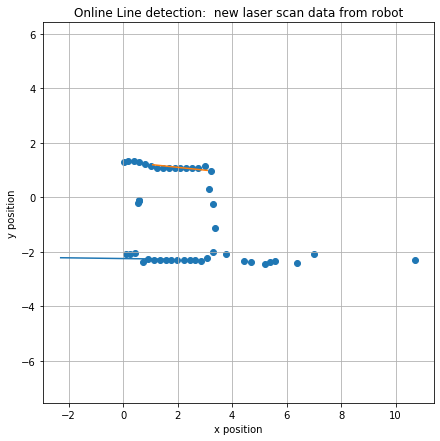

In [275]:
import numpy as np
data = np.loadtxt("./laser_data3.csv")
data = np.abs(data)
print(data.shape)
plotgen(data," new laser scan data from robot")



Number of poinnt:  (70, 2)
end-points:  [[ 0.09465815 -1.80615941]
 [ 5.61047571  1.71537365]]
end-points:  [[15.14472048 11.93907939]
 [ 4.39300065  5.18944479]]
end-points:  [[3.43710004 4.43877688]
 [1.47938551 2.28029458]]
end-points:  [[2.08278912 3.56989098]
 [0.42255625 1.04586341]]
end-points:  [[1.13370363 2.95275769]
 [0.13775585 1.3419683 ]]
desired_wall:  [[ 0.09465815 -1.80615941]
 [ 0.30866556 -1.75513048]
 [ 0.52507551 -1.71469023]
 [ 0.72424149 -1.62716483]
 [ 0.93138765 -1.5052083 ]
 [ 1.13420544 -1.36357058]
 [ 1.34767018 -1.16284747]
 [ 1.55191462 -0.94969271]
 [ 1.77043508 -0.80544217]
 [ 1.99303892 -0.6654497 ]
 [ 2.20848851 -0.52908354]
 [ 2.42882233 -0.39437917]
 [ 2.65042889 -0.25422921]
 [ 2.87433286 -0.11200353]
 [ 3.08684024  0.02777096]
 [ 3.31874661  0.17480022]
 [ 3.54607269  0.32659304]
 [ 3.76391725  0.46259053]
 [ 3.9727133   0.59415539]
 [ 4.19968788  0.74099974]
 [ 4.44503591  0.90494943]
 [ 4.6869078   1.06079619]
 [ 4.90370819  1.20021501]
 [ 5.1377

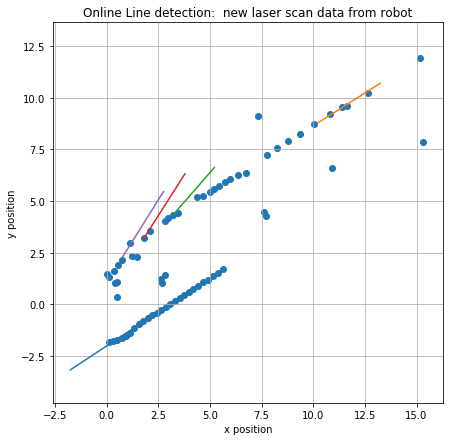

In [276]:
import numpy as np
data = np.loadtxt("./laser_data1.csv")
data = np.abs(data)
plotgen(data," new laser scan data from robot")



Number of poinnt:  (41, 2)
end-points:  [[ 0.09633269 -2.72271656]
 [ 2.90367618 -4.92840941]]
end-points:  [[ 2.78204447 -0.5165054 ]
 [ 0.04549988  1.75399917]]
desired_wall:  [[ 0.09633269 -2.72271656]
 [ 0.3197791  -2.90914208]
 [ 0.54607911 -3.0900699 ]
 [ 0.77054485 -3.26870033]
 [ 0.98333227 -3.32109616]
 [ 1.19745257 -3.33515584]
 [ 1.38519615 -3.3037974 ]
 [ 1.53975603 -3.37868625]
 [ 2.05453775 -4.30619825]
 [ 2.20020152 -4.41292155]
 [ 2.47749024 -4.75817503]
 [ 2.67131598 -4.8186056 ]
 [ 2.90367618 -4.92840941]]
x_min, x_max -2.9091420811621918 0.3197790988924283
desired_wall:  [[ 2.78204447 -0.5165054 ]
 [ 2.5512947  -0.33707876]
 [ 2.31835002 -0.15327145]
 [ 2.08508747  0.02574429]
 [ 1.85432977  0.1933276 ]
 [ 1.65365216  0.35728706]
 [ 1.45876119  0.60322262]
 [ 1.26012197  0.91664296]
 [ 1.04056751  1.13516438]
 [ 0.82902979  1.30231441]
 [ 0.61891405  1.46046639]
 [ 0.40114229  1.49769907]
 [ 0.20590254  1.630533  ]
 [ 0.04549988  1.75399917]]
x_min, x_max -0.33707876

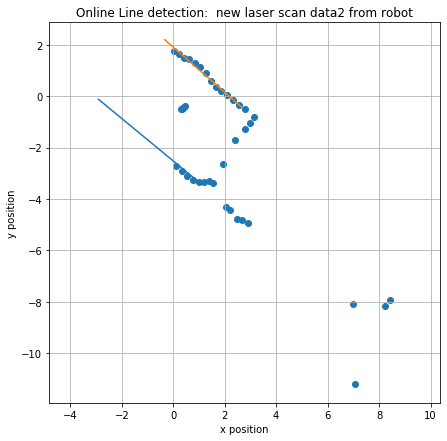

In [277]:
data2 = np.loadtxt("./laser_data2.csv")
data2 = np.abs(data2)
plotgen(data2," new laser scan data2 from robot")
